In [ ]:
!pip install -U autogluon

In [1]:
# 필요한 라이브러리 불러오기
from autogluon.tabular import TabularPredictor

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re

## 데이터 불러오기

In [2]:
# 학습 데이터
train = pd.read_csv('car_prices_regression_dataset/train.csv')

# 테스트 데이터
test = pd.read_csv('car_prices_regression_dataset/test.csv')

# 원본 데이터
Original = pd.read_csv('car_prices_regression_dataset/used_cars.csv')

In [3]:
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
Original.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


## EDA
* 데이터셋 확인
* 결측치 확인
* target 및 데이터 시각화

### 데이터 확인

In [5]:
# 데이터 정보 확인
train.info()
print("\n학습 데이터 갯수: ", train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB

학습 데이터 갯수:  (188533, 13)


In [6]:
# 데이터 통계 정보 확인
train.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [7]:
# 결측치 확인
train.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [8]:
test.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [9]:
# 필요없는 id 컬럼 제거
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

### 데이터 시각화

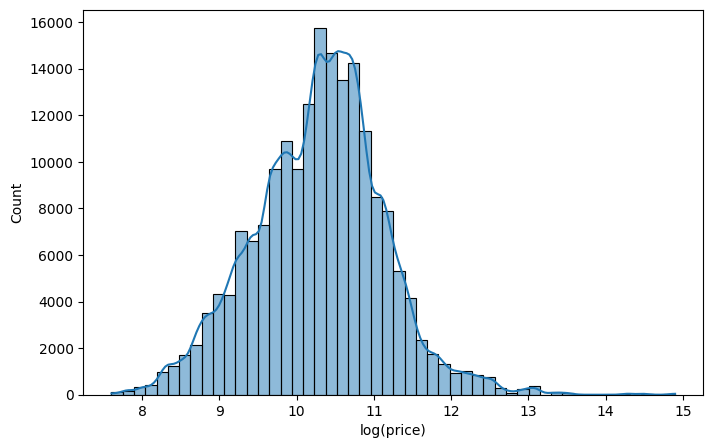

In [10]:
# 목표 변수 시각화
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(train['price']), bins=50, kde=True)
plt.xlabel('log(price)')
plt.ylabel('Count')
plt.show()

array([[<Axes: title={'center': 'model_year'}>,
        <Axes: title={'center': 'milage'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

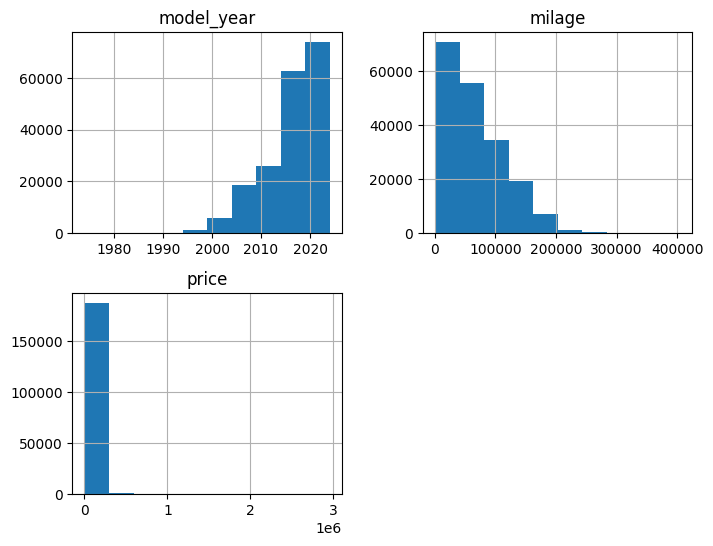

In [11]:
# 히스토그램 시각화
train.hist(figsize=(8, 6))

In [12]:
categorical_columns = train.select_dtypes(include=['object']).columns

# 
unique_values = {col: train[col].nunique() for col in categorical_columns}

for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

brand: 57 unique values
model: 1897 unique values
fuel_type: 7 unique values
engine: 1117 unique values
transmission: 52 unique values
ext_col: 319 unique values
int_col: 156 unique values
accident: 2 unique values
clean_title: 1 unique values


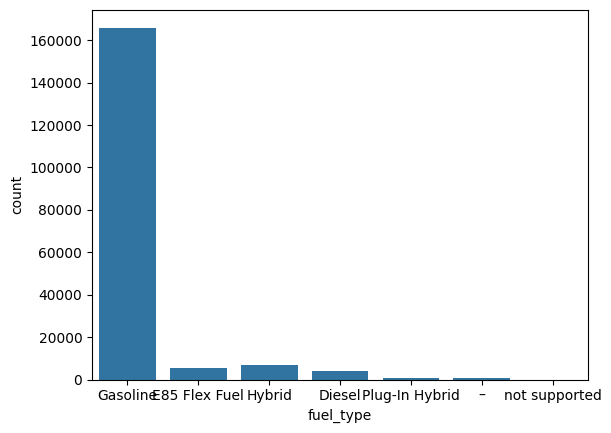

In [13]:
# 연료 유형 시각화
sns.countplot(data=train, x=train['fuel_type'])
plt.show()

Text(0, 0.5, 'Price')

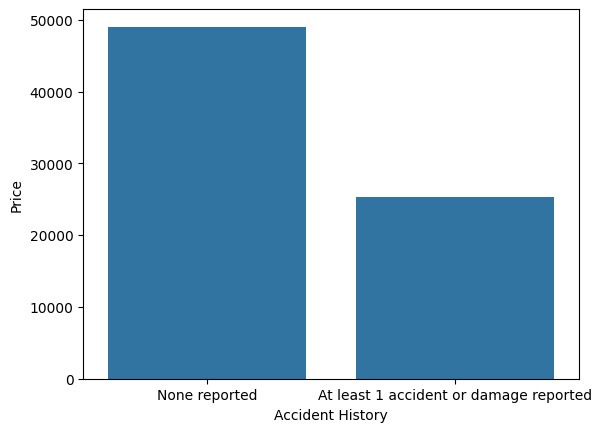

In [14]:
# 사고 이력 대비 중고차 가격 시각화
sns.barplot(x='accident', y='price', data=train, errorbar=None)
plt.xlabel('Accident History')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

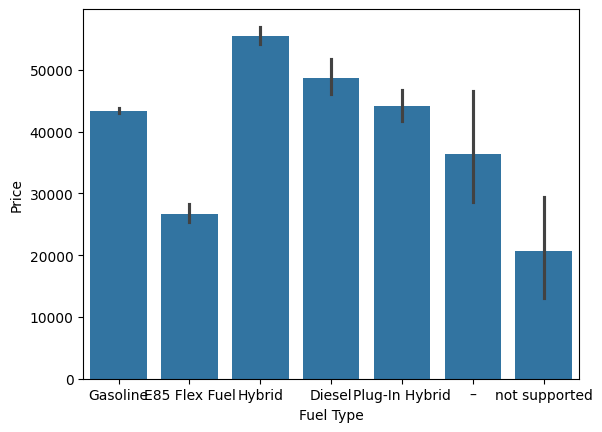

In [15]:
# 연료 종류별 중고차 가격 시각화
sns.barplot(data=train, x='fuel_type', y='price')
plt.xlabel('Fuel Type')
plt.ylabel('Price')

In [16]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩 수행한 학습 데이터 생성을 위해 학습 데이터 복사
train_encoded = train[train.columns].copy()

# 범주형 컬럼만 추출
object_data = train_encoded.select_dtypes(include='object').columns

# 각 범주형 변수에 대해 라벨 인코딩 수행
le = LabelEncoder()
for column in object_data:
    train_encoded[column] = le.fit_transform(train[column])


In [17]:
train_encoded

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31,495,2007,213000,2,116,38,312,71,1,0,4200
1,28,930,2002,143250,2,366,38,263,10,0,0,4999
2,9,1575,2002,136731,1,640,38,38,71,1,0,13900
3,16,758,2017,19500,2,863,49,29,14,1,0,45000
4,36,1077,2021,7388,2,259,23,29,10,1,0,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8,604,2017,49000,2,866,49,304,10,1,0,27500
188529,36,206,2018,28600,2,770,31,304,14,0,0,30000
188530,36,223,2021,13650,2,921,23,304,14,1,0,86900
188531,3,1471,2022,13895,2,512,1,82,14,1,1,84900


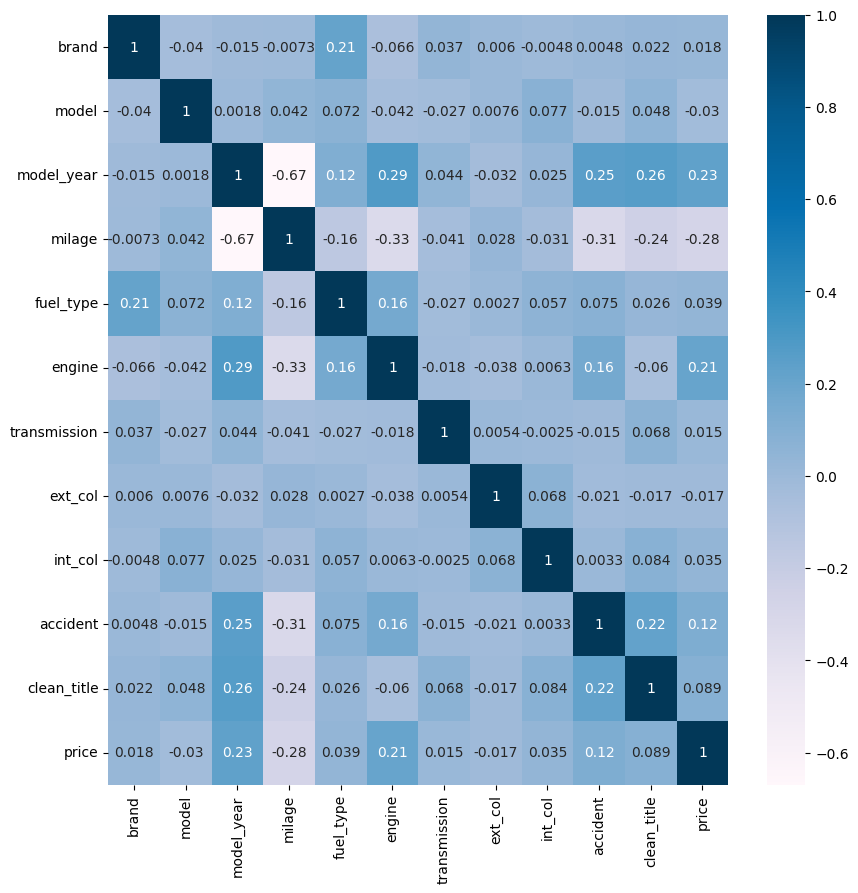

In [18]:
# 상관관계 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(train_encoded.corr(), annot=True, cbar=True, cmap='PuBu')
plt.show()


필사 Notebook
----
[MSE/MAE + Autogluon](https://www.kaggle.com/code/hoon0303/mse-mae-autogluon)

## 데이터 전처리

In [19]:
# 문자열에서 숫자만 추출하여 정수로 변환
Original[['milage', 'price']] = Original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

In [20]:
# train 데이터와 Original 데이터 합치기
train = pd.concat([train, Original], ignore_index=True)

In [21]:
train.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900


In [22]:
# 필요한 라이브러리 불러오기
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor, Pool

from xgboost import XGBRegressor


import random

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from autogluon.tabular import TabularPredictor

In [23]:
# 차량 연식와 관련된 컬럼 생성 함수
def extract_age_features(df):
    current_year = 2024

    # 차량 연식 계산
    df['Vehicle_Age'] = current_year - df['model_year']
    
    # 연간 주행거리 계산
    df['Mileage_per_Year'] = df['milage'] / df['Vehicle_Age']
    
    # 차량 연식별 평균 주행거리
    df['milage_with_age'] =  df.groupby('Vehicle_Age')['milage'].transform('mean')
    
    # 차량 연식별 평균 연간 주행거리
    df['Mileage_per_Year_with_age'] =  df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')
    
    return df

# 고급 브랜드 여부 컬럼 생성 함수
def extract_other_features(df):
    # 고급 브랜드 리스트
    luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    
    # 고급 브랜드 여부 1, 0으로 표시
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    
    return df

In [24]:
# train, test 데이터에 컬럼 생성 함수 적용
train = extract_age_features(train)
test = extract_age_features(test)

train = extract_other_features(train)
test = extract_other_features(test)

In [25]:
train.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Vehicle_Age,Mileage_per_Year,milage_with_age,Mileage_per_Year_with_age,Is_Luxury_Brand
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,12529.411765,118194.992360,6952.646609,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,6511.363636,118270.783105,5375.944687,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,6215.045455,118270.783105,5375.944687,0


In [26]:
def update(df):
    # 빈도수 임계값 설정 
    t = 100
    
    # 범주형 컬럼 추출
    cat_c = ['brand','model','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title',
             
            ]
    
    # 빈도수가 적은 컬럼 추출
    re_ = ['model','engine','transmission','ext_col','int_col']
    
    # 빈도수가 임계값보다 작은 값들을 'noise'로 대체
    for col in re_:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < t, col] = "noise"
    
    # 범주형 컬럼 전처리   
    for col in cat_c:
        df[col] = df[col].fillna('missing')    # 결측값 'missing'으로 대체
        df[col] = df[col].astype('category')    # 데이터 타입 category로 변환
        
    return df

# train, test 데이터에 함수 적용
train  = update(train)
test   = update(test)

In [27]:
train.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Vehicle_Age,Mileage_per_Year,milage_with_age,Mileage_per_Year_with_age,Is_Luxury_Brand
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,12529.411765,118194.992360,6952.646609,0
1,Lincoln,noise,2002,143250,Gasoline,noise,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,6511.363636,118270.783105,5375.944687,0
2,Chevrolet,noise,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,6215.045455,118270.783105,5375.944687,0


In [28]:
# 학습, 테스트 데이터 분할
X = train.drop('price', axis=1)
y = train['price']

## 학습 및 예측
### RMSE 계산 및 MAE, MSE 비교

In [29]:
# 로그 평가 300회마다, 조기 종료 200회로 콜백 함수 설정
callbacks = [log_evaluation(period=300), early_stopping(stopping_rounds=200)]

# 범주형 컬럼 추출
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"cat_cols--------{cat_cols}")


# Out-of-fold 예측 수행 함수
def get_MAE_oof(df, target, lgb_params, cat_params=None, model_type='LGBM'):

    # OOF 예측값을 저장할 배열 초기화
    oof_predictions = np.zeros(len(df))

    # 5-fold 교차 검증을 위한 KFold 객체 생성
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    # 학습된 모델을 저장할 변수 설정
    models = []

    # RMSE 점수를 저장할 변수 설정
    rmse_scores = []
    
    # K-fold 교차 검증 수행
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"Training fold {fold + 1}/{5} with {model_type}")

        # 학습/검증 데이터 분할
        X_train, X_val = df.iloc[train_idx], df.iloc[val_idx]
        y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]

        # LightGBM 모델 학습
        if model_type == 'LGBM':
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
            model = lgb.train(
                lgb_params,
                train_data,
                valid_sets=[train_data, val_data],
                valid_names=['train', 'valid'],
                callbacks=callbacks    
            )
        
        # CatBoost 모델 학습
        elif model_type == 'CAT':
            train_data = Pool(data=X_train, label=y_train , cat_features=cat_cols)
            val_data = Pool(data=X_val, label=y_val , cat_features=cat_cols )
            
            model = CatBoostRegressor(**cat_params)
            model.fit(train_data, eval_set=val_data, verbose=150, early_stopping_rounds=200)
        
        # 학습된 모델 저장
        models.append(model)
        
        # 검증 데이터에 대한 예측 수행
        if model_type == 'LGBM':
            pred = model.predict(X_val, num_iteration=model.best_iteration)
        elif model_type == 'CAT':
            pred = model.predict(X_val)
        
        # RMSE 계산 및 저장
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmse_scores.append(rmse)

        print(f'{model_type} Fold RMSE: {rmse}')
        
        # OOF 예측값 저장
        oof_predictions[val_idx] = pred
        
    # 평균 RMSE 출력
    print(f'Mean RMSE: {np.mean(rmse_scores)}')
    return oof_predictions, models

cat_cols--------['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [30]:
# MAE를 목적함수로 하는 LightGBM 파라미터 설정
lgb_params = {
    'objective': 'MAE',
    'n_estimators': 1000,
    'random_state': 1,
}

# MAE 기반 OOF 예측 수행
oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')
X['LGBM_MAE'] = oof_predictions_lgbm

# 테스트 데이터에 대한 예측값 계산 (MAE)
LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MAE'] = LGBM_preds


# MSE를 목적함수로 하는 LightGBM 파라미터 설정
lgb_params = {
    'objective': 'MSE',
    'n_estimators': 1000,
    'random_state': 1,
}

# MSE 기반 OOF 예측 수행
oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')

# MAE와 MSE 예측값의 차이 계산
X['LGBM_MSE_diff'] = oof_predictions_lgbm - X['LGBM_MAE']

# 테스트 데이터에 대한 예측값 계산 (MSE)
LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MSE_diff'] = LGBM_preds - test['LGBM_MAE']

Training fold 1/5 with LGBM
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 154033, number of used features: 16
[LightGBM] [Info] Start training from score 30825.000000
Training until validation scores don't improve for 200 rounds
[300]	train's l1: 16379.4	valid's l1: 16910.1
Early stopping, best iteration is:
[369]	train's l1: 16314.7	valid's l1: 16906.2
LGBM Fold RMSE: 67861.26982972873
Training fold 2/5 with LGBM
[LightGBM] [Warning] Categorical features with more bins than the configured ma

In [32]:
test.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,Vehicle_Age,Mileage_per_Year,milage_with_age,Mileage_per_Year_with_age,Is_Luxury_Brand,LGBM_MAE,LGBM_MSE_diff
0,Land,noise,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,9,10888.888889,81078.503981,9008.722665,1,16402.458527,4280.396289
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes,4,2285.500000,34258.886442,8564.721611,1,57252.126782,15875.930352
2,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,missing,2,14060.500000,17877.043403,8938.521702,0,49451.472824,8181.763131


### Autogluon 사용

In [33]:
X['price'] = y

# AutoGluon TabularPredictor 모델 생성 및 학습
predictor = TabularPredictor(label='price',
                            eval_metric='rmse', 
                            problem_type='regression').fit(X,
                                                       presets='best_quality',
                                                       time_limit=3600*1,    # 학습 시간 제한 (1시간)
                                                       verbosity=2,
                                                       num_gpus=0,    # GPU 사용하지 않음
                                                       included_model_types=['GBM', 'CAT']    # GBM과 CatBoost 모델만 사용
                                                      )

No path specified. Models will be saved in: "AutogluonModels\ag-20250518_101634"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       15.52 GB / 31.92 GB (48.6%)
Disk Space Avail:   344.70 GB / 930.62 GB (37.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then hold

(_ray_fit pid=21792) [1000]	valid_set's rmse: 64344.2


(_dystack pid=12344) 	-72937.2184	 = Validation score   (-root_mean_squared_error)
(_dystack pid=12344) 	16.21s	 = Training   runtime
(_dystack pid=12344) 	4.79s	 = Validation runtime
(_dystack pid=12344) Fitting model: CatBoost_r137_BAG_L1 ... Training model for up to 235.75s of the 533.68s of remaining time.
(_dystack pid=12344) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=3.20%)
(_ray_fit pid=6172) 	Ran out of time, early stopping on iteration 925.
(_dystack pid=12344) 	-72922.317	 = Validation score   (-root_mean_squared_error)
(_dystack pid=12344) 	188.96s	 = Training   runtime
(_dystack pid=12344) 	0.17s	 = Validation runtime
(_dystack pid=12344) Fitting model: CatBoost_r13_BAG_L1 ... Training model for up to 43.02s of the 340.95s of remaining time.
(_dystack pid=12344) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=3.28%)

In [34]:
y_pred = predictor.predict(test)

In [35]:
y_pred

0         19223.000000
1         76909.164062
2         57962.128906
3         29732.607422
4         31227.130859
              ...     
125685    28348.781250
125686    54822.535156
125687    19507.269531
125688    16056.833984
125689    40873.679688
Name: price, Length: 125690, dtype: float32